# XOR probléma megoldása Torch segítségével

In [1]:
require "torch"
require "nn"
require "optim"
GITHUB=true -- legyen true, ha GitHubon is lathato kepeket szeretnenk

In [2]:
-- tanito adatok (beX, beY, ki) formatumban
data=torch.Tensor(4,3)
data[1]=torch.Tensor({0,0,0})
data[2]=torch.Tensor({0,1,1})
data[3]=torch.Tensor({1,0,1})
data[4]=torch.Tensor({1,1,0})

In [3]:
-- MLP halo megkonstrualasa
inputs=2
hidden_neurons=20
outputs=1
model=nn.Sequential()
model:add(nn.Linear(inputs,hidden_neurons))
model:add(nn.Tanh())
model:add(nn.Linear(hidden_neurons,outputs))
model:add(nn.Tanh())
criterion=nn.MSECriterion() -- koltsegfuggveny: negyzetes hiba

In [4]:
-- tanitasi parameterek
coefL1=0.0   -- L1 regularizacio parametere
coefL2=1e-3  -- L2 regularizacio parametere
optimState={ -- SGD beallitasai
    learningRate=0.05,     -- tanulasi rata
    weightDecay=0,         -- ez az L2 reg. lenne, de most magunknak irjuk meg
    momentum=0,            -- momentum
    nesterov=false,        -- Nesterov vagy sima momentum
    dampening=0,           -- momentum csillapitasa
    learningRateDecay=1e-5 -- tanulasi rata csokkentese a tanitas kozben
}
epoch=2000  -- epoch szam
batchSize=2 -- batch meret

In [5]:
if(batchSize>data:size(1)) then
    print("Hiba: batch meret nagyobb az adatok szamanal!")
    error()
end
batchInputs=torch.Tensor(batchSize,data:size(2)-1) -- bemenetek egy batch-ben
batchLabels=torch.Tensor(batchSize) -- kimenetek egy batch-ben
losses=torch.Tensor(epoch) -- hiba
params,gradParams=model:getParameters() -- view a sulyokra es a gradiensekre
--[[ ha GPU tamogatassal szeretnenk dolgozni:

require "cutorch"
require "cunn"
model:cuda()
criterion:cuda()
data=data:cuda()
batchInputs=batchInputs:cuda()
batchLabels=batchLabels:cuda()

]]--

In [6]:
-- mini-batch tanitas
print("Tanitas...");
for i=1,epoch do
    local shuffle=torch.randperm(data:size(1)) -- indexek veletlenszeruen megkeverve
    for k=1,data:size(1),batchSize do -- vegiglepkedunk a batch-eken
        local no=1
        for j=k,math.min(k+batchSize-1,data:size(1)) do -- egy batch osszeallitasa
            batchInputs[no]=data[{shuffle[j],{1,2}}]
            batchLabels[no]=data[{shuffle[j],3}]
            no=no+1
        end
        
        local function feval(params) -- sulyokbol kiszamitja a hibat es a gradienseket
            gradParams:zero()
            local outputs=model:forward(batchInputs) -- a halo mukodtetese a batch-re
            local loss=criterion:forward(outputs,batchLabels) -- hiba
            local dloss_doutput=criterion:backward(outputs,batchLabels) -- delta
            model:backward(batchInputs,dloss_doutput) -- gradiensek
            if coefL1~=0 or coefL2~=0 then -- regularizacio
                loss=loss+coefL1*torch.norm(params,1)
                loss=loss+0.5*coefL2*torch.norm(params,2)^2
                gradParams:add(torch.sign(params):mul(coefL1)+params:clone():mul(coefL2))
            end
            return loss,gradParams
        end
        
        _,loss=optim.sgd(feval,params,optimState)
        losses[i]=loss[1]
    end
end
print("Tanitas kesz!")

Tanitas...	


Tanitas kesz!	


In [7]:
-- a halo mukodtetese a tanito adatokra
print("Modell kimenete:")
print(model:forward(data[{{},{1,2}}]))
print("Elvart kimenet:")
print(data[{{},3}])

Modell kimenete:	
 0.0047
 0.9442
 0.9432
 0.0065
[torch.DoubleTensor of size 4x1]

Elvart kimenet:	
 0
 1
 1
 0
[torch.DoubleTensor of size 4]



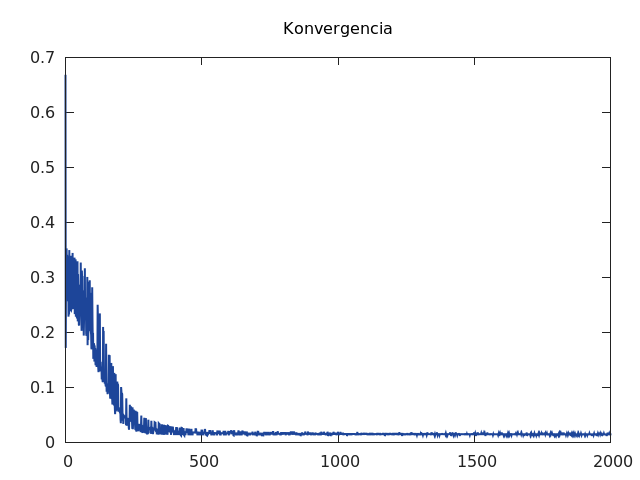

In [8]:
-- hiba abrazolasa
local x=torch.linspace(0,epoch,epoch)
if GITHUB then
    require "gnuplot"
    gnuplot.pngfigure("plot.png")
    gnuplot.plot(x,losses,"-")
    gnuplot.title("Konvergencia")
    gnuplot.plotflush()
    local t0=os.clock()
    while ((os.clock()-t0)<3) do end -- varunk egy kicsit, hogy elkeszuljon a fajl
    itorch.image("plot.png")
    os.remove("plot.png") -- toroljuk a fajlt
else -- ez egy JavaScript alapu interaktiv plot, de a GitHub nem jeleniti meg
    local plot=itorch.Plot()
    plot:line(x,losses)
    plot:title("Konvergencia")
    plot:draw()
end

In [9]:
print(params) -- a halo sulyai

 1.7976
 1.8042
 0.1564
 0.5677
 0.2574
-0.3490
-0.4262
 0.7857
 0.7968
-0.6390
 0.3886
-0.4644
 0.1505
-0.4660
-0.5550
-0.6237
-0.1941
 0.6249
-0.2791
 0.5530
 0.3993
 0.5182
-0.1515
-0.2670
-0.2017
-0.0220
 0.1170
 0.1152
-0.4237
-0.0010
-0.8906
 0.3863
-0.4347
-0.2606
 0.5617
 0.6067
-0.5714
-0.1630
-0.2129
-0.1395
-0.5159
-0.4090
-0.2748
 0.2272
 0.5405
-0.4574
-0.3523
 0.9257
-0.0744
 0.4434
-0.7118
 0.3759
 0.3046
-0.2191
-0.1120
-0.2056
 0.4989
-0.9179
-0.3118
 0.1371
 2.2413
-0.2447
 0.1384
-0.4199
-0.6993
 0.3424
 0.2515
 0.7473
-0.2120
-0.3614
-0.5550
 0.2120
 0.1322
-0.1244
 0.1702
 0.6559
 0.4377
-0.7606
-0.0616
 0.0420
 0.1640
[torch.DoubleTensor of size 81]

